In [1]:

from keras.applications import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input
from keras.models import Model
from keras.layers import Input, Dropout, Dense, Embedding, MultiHeadAttention, LayerNormalization, Layer, Concatenate, add
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import load_img
from sklearn.model_selection import KFold
import tensorflow as tf
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from glob import glob
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from string import punctuation
from tqdm import tqdm

# Process Captions
To process the captions, I make all of the text lowercase and remove characters that are not letters or whitespace (i.e. numbers, punctuation, other symbols). I also add START and END tokens. I then tokenize the sequences. Finally, I remove stopwords. Stopwords are words like "a," "if," "is" that do not carry much meaning. Removing stopwords from both inputs and targets means that generated sequences will lose some fluency, but for captioning images, this is not too much of a problem - the main goal is to identify objects and backgrounds in images.

In [2]:
df_captions = pd.read_csv('captions.txt')
df_captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


I keep only the first description for each image.

In [3]:
def remove_punct(str):
    output = ''
    for char in str:
        if char not in punctuation:
            output += char
        else:
            output += ' '
    return output

word_tokenize(remove_punct('light-colored. '))

['light', 'colored']

In [4]:
stop_words = stopwords.words('english')
df_captions['caption'] = df_captions['caption'].apply(remove_punct)
df_captions['caption'] = df_captions['caption'].apply(lambda x: 'START ' + ''.join([char for char in x if char.isalpha() or char == ' ']).strip().lower() + ' END')
df_captions['caption'] = df_captions['caption'].apply(lambda x: word_tokenize(x))
df_captions['caption'] = df_captions['caption'].apply(lambda x: [word for word in x if word not in ['a', 'an', 'the'] and len(word) > 1])

df_captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,"[START, child, in, pink, dress, is, climbing, ..."
1,1000268201_693b08cb0e.jpg,"[START, girl, going, into, wooden, building, END]"
2,1000268201_693b08cb0e.jpg,"[START, little, girl, climbing, into, wooden, ..."
3,1000268201_693b08cb0e.jpg,"[START, little, girl, climbing, stairs, to, he..."
4,1000268201_693b08cb0e.jpg,"[START, little, girl, in, pink, dress, going, ..."


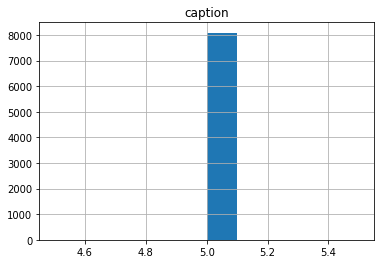

In [5]:
df_captions.groupby('image').count().hist()
plt.show()

As shown above, each image has five captions

# Separating Train and Test Images

Next, I separate the image file names into train and test sets.

In [6]:

img_ids = df_captions['image'].unique()
train_size = 0.9
val_size = 0.1
test_idx = int(len(img_ids) * train_size)
val_idx = int(test_idx * (1-val_size))
train_ids = img_ids[:val_idx]
val_ids = img_ids[val_idx:test_idx]
test_ids = img_ids[test_idx:]

# Vectorizing Captions

In [7]:
# Make a lookup dictionary to map tokens to integers
def flatten_corpus(corpus):
    flat_corpus = []
    for line in corpus:
        flat_corpus.extend(line)
    return flat_corpus

def make_tok2idx(corpus):
    flat_corpus = flatten_corpus(corpus)
    unique_toks = list(set(flat_corpus))
    tok2idx = {'PAD':0, 'UNK':1}
    tok_idx = 2
    for tok in unique_toks:
        tok2idx[tok] = tok_idx
        tok_idx += 1
    return tok2idx

df_train = df_captions.loc[df_captions['image'].isin(train_ids), 'caption']
tok2idx = make_tok2idx(df_train)
idx2tok = dict((value, key) for key, value in tok2idx.items())    

In [8]:

def vectorize_seq(sequence):
    vector = []
    for tok in sequence:
        next_idx = tok2idx.get(tok)
        if next_idx is not None:
            vector.append(next_idx)
        else:
            vector.append(tok2idx['UNK'])
    return vector

def get_max_len(sequences):
    sequences = [vectorize_seq(seq) for seq in sequences]
    max_len = np.max([len(vector) for vector in sequences])
    return max_len

max_len = get_max_len(df_train)

# Image Feature Extraction
To extract features from images, I use a ResNet50V2 model with ImageNet weights. Note the final layer is an average pooling layer.

In [9]:
target_size = (224, 224) # original resnet size

resnet = ResNet50V2(include_top=False, input_shape=target_size + (3,), pooling='avg')
resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

To save on memory, I will not load the images now. Rather, I will write a generator that will load samples as the models train.

In [10]:
def load_img_descriptions(img_ids, max_len=max_len):
    descriptions = df_captions.loc[df_captions['image'].isin(img_ids)]['caption'].values
    descriptions = [vectorize_seq(description) for description in descriptions]
    inputs = np.zeros((len(descriptions), max_len))
    targets = np.zeros((len(descriptions), max_len))
    
    for i, description in enumerate(descriptions):
        for j, tok in enumerate(description):
            
            inputs[i][j] = tok
            if j > 0: # targets = inputs shifted by 1
                targets[i][j-1] = tok
    return inputs, targets

In [11]:
def data_gen(img_ids, img_dir, batch_size):
    '''
    Yields a batch of data: text inputs, text targets, and image features.
    '''
    while True:
        num_samples = len(img_ids)
        start_idx = 0
        num_caption_per_img = 5
        for i in range(0, num_samples, batch_size):
            
            # Get a batch of ids
            end_idx = start_idx + batch_size
            if end_idx >= num_samples:
                batch = img_ids[start_idx:]
            else:
                batch = img_ids[start_idx:end_idx]
            start_idx += batch_size
            
            # Load images
            img_locs = [img_dir+'/'+id for id in batch]
            images = np.asarray([np.asarray(load_img(img_loc, target_size=target_size)) for img_loc in img_locs])
            images = np.asarray([preprocess_input(img) for img in images])
            img_features = resnet.predict(images, verbose=0)
            img_features = tf.concat([tf.repeat(tf.expand_dims(feats, axis=0), num_caption_per_img, axis=0) for feats in img_features], axis=0)
            
            # Get text sequences
            text_inputs, text_targets = load_img_descriptions(batch)
            

            yield (text_inputs, img_features), text_targets

# Positional Embeddings and Transformer Decoder
This section contains layers needed for the transformer and a layer to combine text and image features. The first is a positional embedding feature. Transformers have many benefits over RNNs, but they do not by themselves encode position. The positional embedding here is simple. The model learns embeddings both encode positional information and semantic information. The positional embeddings are an element-wise sum of those weights.

The transformer is the transformer decoder from [Attention is All You Need](https://arxiv.org/abs/1706.03762). While it does not affect the architecture of the transformer decoder, it should be noted that in the paper the transformer was used for machine translation in a sequence to sequence architecture, thus the decoder performed self-attention and attention between source and target language sequences. Here, the decoder only performs self-attention.

Finally, there is a custom addition layer.  Here, the image features are (batch_size, 2048), but transformer outputs are (batch_size, max_len, embed_dim). I project the image layers down to embed_dim with a dense layer, then pass those projections to the custom addition layer. This addition layer repeats the image feature projections and reshapes them to (batch_size, max_len, embed_dim), i.e. each batch has max_len image feature projections. The image features and transformer outputs can then be added together.

This custom addittion layer is simply an extrapolation from the process in [Where to Put the Image in an Image Captioning Model](https://arxiv.org/abs/1703.09137). In [Where to Put the Image in an Image Captioning Model](https://arxiv.org/abs/1703.09137), addition is described as the best way to combine image and text features. However in that paper, they use an RNN where I use the transformer decoder (in addition to performing a slightly diifferent training task, discussed below). Thus in that application addition is trivial - the image features are of some fixed size, say (1, feature_size), so if the RNN's hidden vectors are made to be the same size, the final RNN hidden statee can be added to the image features.

In [12]:
class PositionalEmbedding(Layer):
    def __init__(self, seq_len, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.tok_embedding = Embedding(vocab_size, embed_dim)
        self.pos_embedding = Embedding(seq_len, embed_dim)
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        
    def call(self, x):
        tok_embeds = self.tok_embedding(x)
        
        positions = tf.range(0, tf.shape(x)[-1])
        pos_embeds = self.pos_embedding(positions)
        return tf.add(pos_embeds, tok_embeds)
    
    def compute_mask(self, inputs, mask=None):
        mask = tf.math.not_equal(inputs, 0)
        return mask
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                'seq_len': self.seq_len,
                'vocab_size': self.vocab_size,
                'embed_dim': self.embed_dim
            }
        )
        return config

In [13]:
class TransformerDecoder(Layer):
    def __init__(self, num_heads, embed_dim, dense_units, dropout=0.0, **kwargs):
        '''
        Transformer decoder using Vaswani attention.
        Parameters: num_heads, number of heads for multi-head attention
                    embed_dim, embedding dimension of input sequences
                    dense_units, number of units in non-linear dense layer
        '''
        super().__init__(**kwargs)
        self.self_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout)
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout)
        self.dense = Dense(dense_units, activation='relu')
        self.linear = Dense(embed_dim)
        self.self_attention_layernorm = LayerNormalization()
        self.attention_layernorm = LayerNormalization()
        self.dense_layernorm = LayerNormalization()
        self.num_heads = num_heads
        self.key_dim = embed_dim # Note any key's last dimension should be the embed size, else error when dense layer project
        self.dense_units = dense_units
        self.supports_masking = True
        self.dropout_rate = dropout
        
    def call(self, query, values, mask=None, track_weights=False):
        '''
        Forward pass for transformer decoder using Vaswani attention
        '''
        # Make causal masks
        causal_mask = self.make_causal_mask(query)
        
        # Make padding mask
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            padding_mask = tf.minimum(padding_mask, causal_mask) # Masks both "future" targets the model shouldn't see and padding tokens
        
        # Self-attention
        self_attention_output = self.self_attention(query, query, attention_mask=causal_mask)
        normed_self_attention_output = self.self_attention_layernorm(values + self_attention_output)
        
        # Attention over encoder inputs
        attention_output = self.attention(normed_self_attention_output, values, attention_mask=padding_mask)
        normed_attention_outputs = self.attention_layernorm(attention_output + normed_self_attention_output)
        
        # Projections wiith dense layers
        x = self.dense(normed_attention_outputs)
        x = self.linear(x)
        decoder_outputs = self.dense_layernorm(x + normed_attention_outputs)
        
        return decoder_outputs
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                'num_heads': self.num_heads,
                'key_dem': self.key_dim,
                'dense_units': self.dense_units,
                'dropout_rate': self.dropout_rate
            }
        )
        return config
        
    def make_causal_mask(self, inputs): # (don't forget to modify to self, input when implementing)
        '''
        Makes a mask to prevent attention layers from seeing future characters during training
        '''
        inputs_shape = tf.shape(inputs) # using this as opposed to .shape handles the None batch size in placeholder tensors
        batch_size, seq_len = inputs_shape[0], inputs_shape[1]
        a = tf.range(seq_len)[:, tf.newaxis]
        b = tf.range(seq_len)

        causal_mask = tf.cast(a >= b, 'int32') # creates a (seq_len, seq_len) LT matrix with ones on and below diag

        # Stack batch_size causal masks on top of each other
        causal_mask = tf.reshape(causal_mask, (1, seq_len, seq_len))
        mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1,1], dtype='int32')], axis=0)
        causal_mask = tf.tile(causal_mask, mult)
        return causal_mask

In [14]:

class AddImageToText(Layer):
    '''
    Adds the feature from an image to the output of a transformer called on a text sequence.
    '''
    def __init__(self, seq_len, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.supports_masking = True
        
    def call(self, img, text_sequence):
        img = tf.repeat(img, self.seq_len, axis=0)
        img = tf.reshape(img, shape=(-1, self.seq_len, self.embed_dim))
        sum = tf.add(img, text_sequence)
        return sum
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                'embed_dim': self.embed_dim,
                'seq_len': self.seq_len
            }
        )
        return config

# Build Model
The model architecture is very similar to an encoder-decoder architecture, but with separate "encoders" for text and image data. The encoder for the image data is just the pretrained resnet model - this is called in the data generator. The encoder for the text data is a transformer. Since transformers have no concept of sequence order, positional embeddings are used. The encoded data is combined and fed into the decoder, which is a simple classification model. The outputs are sequences of distributions calculated using a softmax function. In this sense, the model is roughly a sequence to sequence model.

This model is similar to the injection model described in the paper [Where to Put the Image in an Image Captioning Model](https://arxiv.org/abs/1703.09137) with two notable exceptions. First, the paper uses an RNN as the text encoder, while I use a transformer. Second, my model is trained an a pseudo-sequence-to-sequence fashion in the sense that inputs are a sequence and outputs are the sequence shifted by one. This is a more natural use of a transformer than the training method described in the paper, in my opinion.

In [15]:
num_heads = 4
transformer_dense_units = 1024
transformer_dropout_rate = 0.6
dropout_rate = 0.7
embed_dim = 256
vocab_size = len(tok2idx)

In [16]:
def make_model(num_heads, embed_dim, transformer_dense_units, dense1_size, dense2_size, dropout_rate, transformer_dropout_rate):
    # Text encoder
    text_inputs = Input(shape=(None,), name='text_inputs')
    text_embedding_layer = PositionalEmbedding(seq_len=max_len, vocab_size=vocab_size, embed_dim=embed_dim, name='text_embeds')
    text_embeds = text_embedding_layer(text_inputs)
    text_transformer1 = TransformerDecoder(num_heads=num_heads, embed_dim=embed_dim, dense_units=transformer_dense_units, dropout=transformer_dropout_rate)
    text_transformer2 = TransformerDecoder(num_heads=num_heads, embed_dim=embed_dim, dense_units=transformer_dense_units, dropout=transformer_dropout_rate)

    text_encoded = text_transformer1(text_embeds, text_embeds)
    text_encoded = Dropout(dropout_rate)(text_encoded)


    # Image_encoder
    image_inputs = Input(shape=(2048,), name='image_inputs')
    image_encoded = Dense(embed_dim, activation='relu')(image_inputs)

    # Combine encoded data
    encoded = AddImageToText(seq_len=max_len, embed_dim=embed_dim)(image_encoded, text_encoded)

    # "Decoder"
    x = Dropout(dropout_rate)(encoded)
    x = Dense(dense1_size, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense2_size, activation='relu')(x)
    outputs = Dense(vocab_size, activation='softmax')(x)

    model = Model([text_inputs, image_inputs], outputs)
    
    return model

# Cross Validation

In [17]:
num_heads, embed_dim, transformer_dense_units, 2048, 1024, dropout_rate, transformer_dropout_rate

(4, 256, 1024, 2048, 1024, 0.7, 0.6)

In [18]:
num_head_range = np.linspace(2, 16, 8, dtype=np.int16)
embed_dim_range = np.asarray([2**i for i in np.linspace(6, 8, 3, dtype=np.int16)])
transformer_dense_units_range = np.asarray([2**i for i in np.linspace(6, 10, 5, dtype=np.int16)])
dense1_range = np.asarray([2**i for i in np.linspace(8, 11, 4, dtype=np.int16)])
dense2_range = np.asarray([2**i for i in np.linspace(8, 11, 4, dtype=np.int16)])
dropout_rate_range = np.linspace(0.4, 0.7, 4, np.float16)
transformer_dropout_rate_range = np.linspace(0.4, 0.7, 4, np.float16)


In [19]:
np.linspace(2, 16, 8, dtype=np.int16)

array([ 2,  4,  6,  8, 10, 12, 14, 16], dtype=int16)

In [20]:
np.linspace(6, 10, 5)

array([ 6.,  7.,  8.,  9., 10.])

In [21]:
'_'.join(str(i) for i in list(range(10)))

'0_1_2_3_4_5_6_7_8_9'

In [22]:
batch_size = 6 # This corresponds to 30 sets of inputs a batch       

def cv_round(num_heads, embed_dim, transformer_dense_units, dense1, dense2, dropout_rate, transformer_dropout_rate):
    '''
    Performs 5-Fold cross validation for a set of parameters
    '''
    params = [num_heads, embed_dim, transformer_dense_units, dense1, dense2, dropout_rate, transformer_dropout_rate]
    param_string = '_'.join([str(param_val) for param_val in params])
    kf = KFold(n_splits=5)
    losses = []
    
    for train_idxs, test_idx in kf.split(train_ids):
        # Get train and test image IDs and make generators for each
        cv_train_ids = [train_ids[idx] for idx in train_idxs]
        cv_test_ids = [train_ids[idx] for idx in test_idx]
        
        cv_train_gen = data_gen(cv_train_ids, 'images', batch_size=batch_size)
        cv_test_gen = data_gen(cv_test_ids, 'images', batch_size=batch_size)
        
        # Create and fit the model for the split
        model = make_model(num_heads, embed_dim, transformer_dense_units, 2048, 1024, dropout_rate, transformer_dropout_rate)

        lr = ReduceLROnPlateau(monitor='val_loss', verbose=1, min_delta=0.0001, patience=5, min_lr=1e-6)
        es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)

        model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy')
        model.fit(cv_train_gen, 
                steps_per_epoch=len(cv_train_ids)//batch_size,
                validation_data=cv_test_gen,
                validation_steps=len(cv_test_ids)//batch_size,
                epochs=100, 
                callbacks=[lr, es],
                verbose=0)
        
        # calculate the loss for the split
        split_loss = model.evaluate(cv_test_gen, steps=len(cv_test_ids)//batch_size, verbose=False)        
        # Add loss to list off losses
        losses.append(split_loss)
    
    # Save model
    model_name = 'cv_model_'+param_string
    model.save_weights(model_name+'.h5')
    
    return np.mean(losses), model_name

def do_cv(num_cv_rounds):
    '''
    Performs cross validation for cv_rounds random values of hyperparameters
    '''
    # Define range of values
    num_heads_range = np.linspace(2, 16, 8, dtype=np.int16)
    embed_dim_range = np.asarray([2**i for i in np.linspace(6, 8, 3, dtype=np.int16)])
    transformer_dense_units_range = np.asarray([2**i for i in np.linspace(6, 10, 5, dtype=np.int16)])
    dense1_range = np.asarray([2**i for i in np.linspace(8, 11, 4, dtype=np.int16)])
    dense2_range = np.asarray([2**i for i in np.linspace(8, 11, 4, dtype=np.int16)])
    dropout_rate_range = np.linspace(0.4, 0.7, 4, np.float16)
    transformer_dropout_rate_range = np.linspace(0.4, 0.7, 4, np.float16)
    
    model_names = []
    model_losses = []
    
    for round in tqdm(range(num_cv_rounds)):
        # Choose random parameter values
        num_heads = np.random.choice(num_heads_range)
        embed_dim = np.random.choice(embed_dim_range)
        transformer_dense_units = np.random.choice(transformer_dense_units_range)
        dense1 = np.random.choice(dense1_range)
        dense2 = np.random.choice(dense2_range)
        dropout_rate = np.random.choice(dropout_rate_range)
        transformer_dropout_rate = np.random.choice(transformer_dropout_rate_range)
        
        params = [num_heads, embed_dim, transformer_dense_units, dense1, dense2, dropout_rate, transformer_dropout_rate]
        param_string = '_'.join([str(param_val) for param_val in params])
        
        # Perform five fold cross validation for the parameters
        round_loss, round_model_name = cv_round(num_heads, embed_dim, transformer_dense_units, dense1, dense2, dropout_rate, transformer_dropout_rate)
        
        # Save the cross validation results for the parameters
        model_names.append(round_model_name)
        model_losses.append(round_loss)
        
        print(f'Loss for round {round}: {round_loss}')
    
    best_idx = np.argmin(model_losses)
    best_model = model_names[best_idx]
    best_loss = model_losses[best_idx]
    print(f'Param string {param_string}')
    print(f'Best loss {best_loss}')
    
    return best_model

do_cv(20)

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 24: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 30: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 21: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 27: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 25: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 31: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 22: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 27: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 22: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 28: ReduceLROnPlateau reducing learning rate to 1e-06.


  5%|▌         | 1/20 [4:53:19<92:53:08, 17599.38s/it]

Loss for round 0: 1.1719788789749146

Epoch 26: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 33: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 30: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 36: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 28: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 34: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 19: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 26: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 24: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 30: ReduceLROnPlateau reducing learning rate to 1e-06.


 10%|█         | 2/20 [8:56:09<79:05:19, 15817.75s/it]

Loss for round 1: 1.1704197883605958

Epoch 16: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 21: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 18: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 23: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 17: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 22: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 16: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 21: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 16: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 21: ReduceLROnPlateau reducing learning rate to 1e-06.


 15%|█▌        | 3/20 [11:16:45<58:46:37, 12446.89s/it]

Loss for round 2: 1.136533522605896

Epoch 52: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 63: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 54: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 66: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 68: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 73: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 67: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 72: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 65: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 70: ReduceLROnPlateau reducing learning rate to 1e-06.


 20%|██        | 4/20 [19:25:02<84:53:05, 19099.12s/it]

Loss for round 3: 1.3742671966552735

Epoch 41: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 46: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 43: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 50: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 40: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 46: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 37: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 42: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 38: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 44: ReduceLROnPlateau reducing learning rate to 1e-06.


 25%|██▌       | 5/20 [25:18:27<82:44:40, 19858.67s/it]

Loss for round 4: 1.2061284065246582

Epoch 47: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 54: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 44: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 53: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 48: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 56: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 42: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 48: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 37: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 46: ReduceLROnPlateau reducing learning rate to 1e-06.


 30%|███       | 6/20 [31:40:18<81:15:49, 20896.37s/it]

Loss for round 5: 1.2358019828796387

Epoch 26: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 32: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 31: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 37: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 26: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 32: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 21: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 27: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 21: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 27: ReduceLROnPlateau reducing learning rate to 1e-06.


 35%|███▌      | 7/20 [35:39:27<67:43:43, 18755.66s/it]

Loss for round 6: 1.181774663925171

Epoch 44: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 49: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 34: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 39: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 53: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 58: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 39: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 44: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 34: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 39: ReduceLROnPlateau reducing learning rate to 1e-06.


 40%|████      | 8/20 [40:44:00<62:00:24, 18602.01s/it]

Loss for round 7: 1.6245993614196776

Epoch 16: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 22: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 16: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 23: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 16: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 23: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 15: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 21: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 16: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 21: ReduceLROnPlateau reducing learning rate to 1e-06.


 45%|████▌     | 9/20 [43:38:25<49:04:00, 16058.27s/it]

Loss for round 8: 1.1379304885864259

Epoch 62: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 67: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 37: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 56: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 42: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 53: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 37: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 42: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 43: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 54: ReduceLROnPlateau reducing learning rate to 1e-06.


 50%|█████     | 10/20 [50:39:23<52:29:45, 18898.50s/it]

Loss for round 9: 1.369023060798645

Epoch 43: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 50: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 38: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 43: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 39: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 44: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 41: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 46: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 54: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 59: ReduceLROnPlateau reducing learning rate to 1e-06.


 55%|█████▌    | 11/20 [56:10:08<47:58:13, 19188.22s/it]

Loss for round 10: 1.6192435026168823

Epoch 17: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 23: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 17: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 23: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 17: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 24: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 15: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 22: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 15: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 21: ReduceLROnPlateau reducing learning rate to 1e-06.


 60%|██████    | 12/20 [59:15:05<37:10:13, 16726.66s/it]

Loss for round 11: 1.1393316507339477

Epoch 47: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 52: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 31: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 36: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 48: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 53: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 56: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 61: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 35: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 40: ReduceLROnPlateau reducing learning rate to 1e-06.


 65%|██████▌   | 13/20 [64:41:56<34:13:22, 17600.41s/it]

Loss for round 12: 1.6198917865753173

Epoch 79: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 86: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 89: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 96: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 75: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 80: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 75: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 80: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 78: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 83: ReduceLROnPlateau reducing learning rate to 1e-06.


 70%|███████   | 14/20 [74:39:10<38:30:48, 23108.12s/it]

Loss for round 13: 1.35922532081604

Epoch 43: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 48: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 44: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 50: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 45: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 57: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 46: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 51: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 47: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 52: ReduceLROnPlateau reducing learning rate to 1e-06.


 75%|███████▌  | 15/20 [80:55:43<31:52:43, 22952.67s/it]

Loss for round 14: 1.3610347986221314

Epoch 24: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 31: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 32: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 39: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 27: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 35: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 22: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 28: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 25: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 31: ReduceLROnPlateau reducing learning rate to 1e-06.


 80%|████████  | 16/20 [85:17:53<23:05:15, 20778.76s/it]

Loss for round 15: 1.171832227706909

Epoch 44: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 51: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 50: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 59: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 48: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 55: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 46: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 51: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 47: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 53: ReduceLROnPlateau reducing learning rate to 1e-06.


 85%|████████▌ | 17/20 [91:57:13<18:06:45, 21735.30s/it]

Loss for round 16: 1.2312926292419433

Epoch 43: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 50: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 44: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 53: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 49: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 58: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 44: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 49: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 43: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 50: ReduceLROnPlateau reducing learning rate to 1e-06.


 90%|█████████ | 18/20 [99:07:07<12:45:10, 22955.02s/it]

Loss for round 17: 1.2384182214736938

Epoch 47: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 54: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 57: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 64: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 53: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 58: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 47: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 52: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 49: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 56: ReduceLROnPlateau reducing learning rate to 1e-06.


 95%|█████████▌| 19/20 [106:19:47<6:37:37, 23857.25s/it]

Loss for round 18: 1.233807349205017

Epoch 27: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 33: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 25: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 32: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 28: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 34: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 27: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 32: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 23: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 29: ReduceLROnPlateau reducing learning rate to 1e-06.


100%|██████████| 20/20 [110:35:13<00:00, 19905.68s/it]  

Loss for round 19: 1.1680429697036743
Param string 6_128_256_256_512_0.5_0.4
Best loss 1.136533522605896


'cv_model_14_256_256_512_2048_0.5_0.6'

In [23]:
batch_size = 6 # This corresponds to 30 sets of inputs a batch       
train_gen = data_gen(train_ids, 'images', batch_size=batch_size)
val_gen = data_gen(val_ids, 'images', batch_size=batch_size)

lr = ReduceLROnPlateau(monitor='val_loss', verbose=1, min_delta=0.0001, patience=5, min_lr=1e-6)
es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)


model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(train_gen, 
          steps_per_epoch=len(train_ids)//batch_size, 
          validation_data=val_gen, 
          validation_steps=(len(val_ids))//batch_size, 
          epochs=200, 
          callbacks=[lr, es])

NameError: name 'model' is not defined

# Inference

In [ ]:
def vec_to_tok(vector):
    return [idx2tok[tok] for tok in vector]

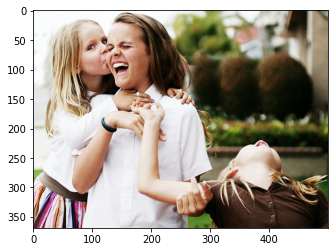

'woman in black shirt is holding up her face'

In [ ]:
def get_caption(img_path):
    caption_string = 'START'
    image = np.asarray(load_img(img_path, target_size=target_size))
    image = np.expand_dims(preprocess_input(image), 0)
    image_features = resnet(image)
    for i in range(max_len):
        caption_idxs = vectorize_seq(caption_string.split(' '))
        vectorized_sentence = np.zeros((1, max_len))
        for i, idx in enumerate(caption_idxs):
            vectorized_sentence[0][i] = idx
        
        # Get next token index
        prediction = model([vectorized_sentence, image_features])
        next_tok_idx = np.argmax(prediction[0, i, :])
        
        # Update string
        next_tok = idx2tok[next_tok_idx]
        caption_string += ' ' + next_tok
        
        # Break if END predicted
        if next_tok == 'END':
            break
        
    if caption_string.endswith('END'):
        return ' '.join(caption_string.split(' ')[1:-1])
    else:
        return ' '.join(caption_string.split(' ')[1:])
    

def plot_img(img_dir, img_id):
    img_loc = img_dir+'/'+img_id
    img = load_img(img_loc)
    plt.imshow(img)
    plt.show()
    return img_loc
    
loc = plot_img('images', test_ids[251])
get_caption(loc)